# HW2: Evaluation of TFLite Accuracy & Size

Use this notebook to measure TFLite and Accuracy of your model.

### Import the required modules

In [1]:
import tensorflow as tf
import numpy as np
import os
import zipfile
from glob import glob
import random

from tensorflow.keras import regularizers


from reader import AudioReader
from preprocessing import Padding, Normalization  
from preprocessing import MelSpectrogram
from preprocessing import MFCC

2025-01-03 23:05:27.280477: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-03 23:05:27.285225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 23:05:27.321550: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 23:05:27.323689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-03 23:05:28.230408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Set Model & Hyperparameters

**You may only modify the following cell by setting the values for `MODEL_FILE_NAME` and `PREPROCESSING_ARGS`. Ensure that the `PREPROCESSING_ARGS` values match those used during training. No other modifications are permitted in this notebook.**

In [2]:
# where we store the dataset
DATASET_PATH = '/tmp/'

SEED = 42

PREPROCESSING_ARGS = {
    'sampling_rate': 16000,
    'frame_length_in_s': 0.04,
    'frame_step_in_s': 0.02,
    'num_mel_bins': 40,
    'lower_frequency': 20,
    'upper_frequency': 4000,
    'num_coefficients': 10  # set num_coefficients to 0 if log-Mel Spectrogram features have been used
}

TRAINING_ARGS = {
    'batch_size':32 ,# from 16 
    'learning_rate': 0.01,
    'end_learning_rate': 1e-5,
    'epochs': 25,
    'width_multiplier': 0.6
}

MODEL_NAME = (
    "SR_" + str(PREPROCESSING_ARGS['sampling_rate']) + 
    "_FL_" + str(PREPROCESSING_ARGS['frame_length_in_s']) + 
    "_FS_" + str(PREPROCESSING_ARGS['frame_step_in_s']) + 
    "_NMEL_" + str(PREPROCESSING_ARGS['num_mel_bins']) + 
    "_LF_" + str(PREPROCESSING_ARGS['lower_frequency']) + 
    "_UF_" + str(PREPROCESSING_ARGS['upper_frequency']) + 
    "_NC_" + str(PREPROCESSING_ARGS['num_coefficients']) + 
    "_BS_" + str(TRAINING_ARGS['batch_size']) + 
    "_LR_" + str(TRAINING_ARGS['learning_rate']) + 
    "_E_" + str(TRAINING_ARGS['epochs']) + 
    "_WM_" + str(TRAINING_ARGS['width_multiplier'])
)

MODEL_FILE_PATH =  "./tflite_models/Group06.tflite"


LABELS = ['down', 'up']


# Set seed for Python's built-in random module
random.seed(SEED)

# Set seed for NumPy
np.random.seed(SEED)

# Set seed for TensorFlow
tf.random.set_seed(SEED)

### Create train/val/test Datasets

In [3]:
train_ds = tf.data.Dataset.list_files([DATASET_PATH + '/msc-train/up*', DATASET_PATH + '/msc-train/down*'], seed = SEED)
val_ds = tf.data.Dataset.list_files([DATASET_PATH + '/msc-val/up*', DATASET_PATH + '/msc-val/down*'], seed = SEED)
test_ds = tf.data.Dataset.list_files([DATASET_PATH + '/msc-test/up*',  DATASET_PATH + '/msc-test/down*'], seed = SEED)

### Define the Data Pipeline

In [4]:
audio_reader = AudioReader(tf.int16)
padding = Padding(PREPROCESSING_ARGS['sampling_rate'])
normalization = Normalization(tf.int16)

if PREPROCESSING_ARGS['num_coefficients'] == 0:
    PREPROCESSING_ARGS.pop('num_coefficients')
    feature_processor = MelSpectrogram(**PREPROCESSING_ARGS)
    feature_processor_fn = feature_processor.get_mel_spec_and_label
    PREPROCESSING_ARGS['num_coefficients'] = 0
else:
    feature_processor = MFCC(**PREPROCESSING_ARGS)
    feature_processor_fn = feature_processor.get_mfccs_and_label

def prepare_for_training(feature, label):
    feature = tf.expand_dims(feature, -1)
    label_id = tf.argmax(label == LABELS)

    return feature, label_id

train_ds = (train_ds
            .map(audio_reader.get_audio_and_label)
            .map(padding.pad)
            .map(normalization.normalize)
            .map(feature_processor_fn)
            .map(prepare_for_training)
            .batch(TRAINING_ARGS['batch_size'])
            .cache()
            )
val_ds = (val_ds
            .map(audio_reader.get_audio_and_label)
            .map(padding.pad)
            .map(normalization.normalize)
            .map(feature_processor_fn)
            .map(prepare_for_training)
            .batch(TRAINING_ARGS['batch_size']))
test_ds = (test_ds
            .map(audio_reader.get_audio_and_label)
            .map(padding.pad)
            .map(normalization.normalize)
            .map(feature_processor_fn)
            .map(prepare_for_training)
            .batch(TRAINING_ARGS['batch_size']))

2025-01-03 23:05:30.808855: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 AVX512F FMA
2025-01-03 23:05:30.812669: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


In [5]:
for example_batch, example_labels in train_ds.take(1):
  print('Batch Shape:', example_batch.shape)
  print('Data Shape:', example_batch.shape[1:])
  print('Labels:', example_labels)
  print("example_batch.shape[1:]", example_batch.shape[1:])

Batch Shape: (32, 49, 10, 1)
Data Shape: (49, 10, 1)
Labels: tf.Tensor([0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1], shape=(32,), dtype=int64)
example_batch.shape[1:] (49, 10, 1)
2025-01-03 23:05:33.564279: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Define the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 4, 76)         684       
                                                                 
 batch_normalization (Batch  (None, 24, 4, 76)         304       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 24, 4, 76)         0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 24, 4, 76)         684       
 eConv2D)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 4, 76)         5776      
                                                                 
 batch_normalization_1 (Bat  (None, 24, 4, 76)         3

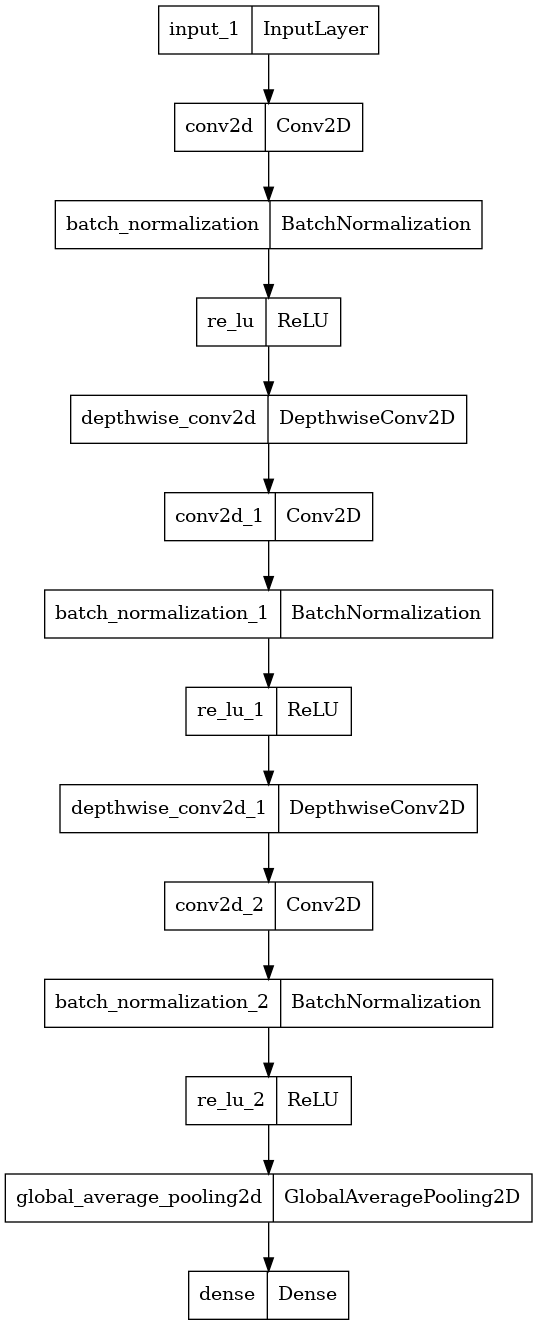

In [6]:
wm = TRAINING_ARGS["width_multiplier"]  # Adjust the width multiplier to control model size

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=example_batch.shape[1:]),

    # First Convolutional Block
    tf.keras.layers.Conv2D(filters=int(128 * wm), kernel_size=[3, 3], strides=[2, 2],
                           use_bias=False, padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # First Depthwise Separable Convolution
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=False, padding='same'),
    tf.keras.layers.Conv2D(filters=int(128 * wm), kernel_size=[1, 1], strides=[1, 1], use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # Second Depthwise Separable Convolution
    tf.keras.layers.DepthwiseConv2D(kernel_size=[3, 3], strides=[1, 1], use_bias=False, padding='same'),
    tf.keras.layers.Conv2D(filters=int(64 * wm), kernel_size=[1, 1], strides=[1, 1], use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # Global Pooling and Output Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=len(LABELS), activation='softmax')
])

print(model.summary())

tf.keras.utils.plot_model(model)

### Train the Model (with Callbacks)

- Modify the `learning_rate` argument of the `Adam` optimizer.
- Modify the `fit` method, specifying the `callbacks` argument.

In [7]:
# Define independent learning rate schedules
linear_decay_optimizer = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.01,  # Custom LR for the optimizer
    end_learning_rate=1e-6,
    decay_steps=len(train_ds) * TRAINING_ARGS['epochs'],
)

linear_decay_callback = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=TRAINING_ARGS['learning_rate'],  # From TRAINING_ARGS
    end_learning_rate=TRAINING_ARGS['end_learning_rate'], 
    decay_steps=int(len(train_ds) * TRAINING_ARGS['epochs'] * 0.3),  # Faster decay for callback
)

# Learning Rate Scheduler callback (uses the callback schedule)
def lr_scheduler_callback(epoch, lr):
    return linear_decay_callback(epoch)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_callback)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='auto'
)

# Compile the model with the optimizer's learning rate schedule
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=linear_decay_optimizer)
metrics = [tf.metrics.SparseCategoricalAccuracy()]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Train the model with independent schedules
history = model.fit(
    train_ds, 
    epochs=TRAINING_ARGS['epochs'],  
    validation_data=val_ds, 
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/25
50/50 [==============================] - 21s 390ms/step - loss: 0.3803 - sparse_categorical_accuracy: 0.8413 - val_loss: 0.4638 - val_sparse_categorical_accuracy: 0.8950 - lr: 0.0096
Epoch 2/25
50/50 [==============================] - 4s 76ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.9456 - val_loss: 0.5509 - val_sparse_categorical_accuracy: 0.7400 - lr: 0.0092
Epoch 3/25
50/50 [==============================] - 4s 78ms/step - loss: 0.1127 - sparse_categorical_accuracy: 0.9613 - val_loss: 0.9660 - val_sparse_categorical_accuracy: 0.6750 - lr: 0.0088
Epoch 4/25
50/50 [==============================] - 4s 75ms/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9694 - val_loss: 0.1609 - val_sparse_categorical_accuracy: 0.9450 - lr: 0.0084
Epoch 5/25
50/50 [==============================] - 4s 76ms/step - loss: 0.0746 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.0524 - val_sparse_categorical_accuracy: 0.9800 - lr: 0.0080
Epoch 6/25
50/50 [====================

### Evaluate the model

In [8]:
training_loss = history.history['loss'][-1]
training_accuracy = history.history['sparse_categorical_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_sparse_categorical_accuracy'][-1]
 
test_loss, test_accuracy = model.evaluate(test_ds)

print(f'Training Loss: {training_loss:.4f}')
print(f'Training Accuracy: {training_accuracy*100.:.2f}%')
print()
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy*100.:.2f}%')
print()
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100.:.2f}%')

7/7 [==============================] - 2s 269ms/step - loss: 0.0158 - sparse_categorical_accuracy: 0.9950
Training Loss: 0.0064
Training Accuracy: 99.81%

Validation Loss: 0.0413
Validation Accuracy: 98.00%

Test Loss: 0.0158
Test Accuracy: 99.50%


### Save the model

In [9]:
model.save("saved_models/tmp-model")

converter = tf.lite.TFLiteConverter.from_saved_model("saved_models/tmp-model")

# Convert the model
tflite_model = converter.convert()

with open(MODEL_FILE_PATH, 'wb') as fp:
    fp.write(tflite_model)

INFO:tensorflow:Assets written to: saved_models/tmp-model/assets
INFO:tensorflow:Assets written to: saved_models/tmp-model/assets
2025-01-03 23:07:35.554792: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-01-03 23:07:35.555579: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-01-03 23:07:35.710146: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: saved_models/tmp-model
2025-01-03 23:07:35.857389: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-01-03 23:07:35.857539: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: saved_models/tmp-model
2025-01-03 23:07:35.861628: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2025-01-03 23:07:35.863152: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-01-0

### Measure TFLite Model Size

In [10]:
model_size = os.path.getsize(MODEL_FILE_PATH)

print("model size is: ", model_size)

model size is:  48136


### Load the TFLite Model

In [11]:
if PREPROCESSING_ARGS['num_coefficients'] == 0:
    PREPROCESSING_ARGS.pop('num_coefficients')
    feature_processor = MelSpectrogram(**PREPROCESSING_ARGS)
    feature_processor_fn = feature_processor.get_mel_spec
else:
    feature_processor = MFCC(**PREPROCESSING_ARGS)
    feature_processor_fn = feature_processor.get_mfccs

In [12]:
if MODEL_FILE_PATH.endswith('.zip'):
    with zipfile.ZipFile(MODEL_FILE_PATH, 'r') as fp:
        fp.extractall('/tmp/')
        model_filename = fp.namelist()[0]
        MODEL_FILE_PATH = '/tmp/' + model_filename

interpreter = tf.lite.Interpreter(model_path=MODEL_FILE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Number of inputs:", len(input_details))
print("Number of outputs:", len(output_details))
print("Input name:", input_details[0]['name'])
print("Input shape:", input_details[0]['shape'])
print("Output name:", output_details[0]['name'])
print("Output shape:", output_details[0]['shape'])

Number of inputs: 1
Number of outputs: 1
Input name: serving_default_input_1:0
Input shape: [ 1 49 10  1]
Output name: StatefulPartitionedCall:0
Output shape: [1 2]
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Test the TFLite Model Accuracy

In [13]:
filenames = glob('/tmp/msc-test/down*') + glob('/tmp/msc-test/up*')

accuracy = 0.0

for filename in filenames:
    audio, true_label = audio_reader.get_audio_and_label(filename)   
    true_label = true_label.numpy().decode()
    
    audio = padding.pad_audio(audio)
    audio = normalization.normalize_audio(audio)
    features = feature_processor_fn(audio)
    features = tf.expand_dims(features, 0)
    features = tf.expand_dims(features, -1)

    interpreter.set_tensor(input_details[0]['index'], features)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    top_index = np.argmax(output[0])
    predicted_label = LABELS[top_index]

    accuracy += true_label == predicted_label

accuracy /= len(filenames)

### Report the Test Results

In [14]:
model_size = os.path.getsize(MODEL_FILE_PATH)
print(f'Accuracy: {100 * accuracy:.3f}%')
print(f'Model size: {model_size / 2 ** 10:.1f}KB')

Accuracy: 99.500%
Model size: 47.0KB


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cbfa3810-8232-4a94-b063-558c45bf0521' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>